In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
import pickle
from sklearn.model_selection import train_test_split
import keras.backend as K
import random
from keras.models import load_model
from MadsNeural_network_500epoch import *

WIRE_ANTENNA = False


C:/Users/nlyho/OneDrive - Aalborg Universitet/7. semester/Git/MachineLearning


In [2]:

if WIRE_ANTENNA == True:
    file_path = "Data/WIRE_results/WIRE_Forward_results_with_band_centre.pkl"
else:
    file_path = "Data/MIFA_results/MIFA_Forward_results_with_band_centre.pkl"

# Load data
with open(file_path, 'rb') as f:
    data_to_load = pickle.load(f)

print(data_to_load.keys())

bandwidth = data_to_load["bandwidth"]
center_frequency = data_to_load["centre_frequency"]
f1f2 = data_to_load["f1f2"]

parameter = data_to_load["Parameter combination"]

#Normalize the data wrt. distribution
parameter_norm = normalize_data(parameter,np.mean(parameter),np.std(parameter), False)
bandwidth_norm = normalize_data(bandwidth,np.mean(bandwidth),np.std(bandwidth), False)
center_frequency_norm = normalize_data(center_frequency,np.mean(center_frequency),np.std(center_frequency), False)

input_vector =  np.asarray([[bandwidth_norm[x], center_frequency_norm[x]] for x in range(len(bandwidth))])
input_vector2 = np.asarray([np.concatenate((input_vector[x], f1f2[x])) for x in range(len(input_vector))])
output_vector = np.asarray(parameter_norm)

print(f'Input vector shape: {input_vector.shape}')
print(f'Output vector shape:{output_vector.shape}')

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(input_vector, output_vector, test_size=0.2, random_state=42)



dict_keys(['Parameter combination', 'S1,1', 'Frequency', 'bandwidth', 'centre_frequency', 'f1f2'])
Input vector shape: (180000, 2)
Output vector shape:(180000, 4)


In [3]:
#Create the model
model = keras.Sequential([
    layers.InputLayer(input_shape=(X_train.shape[1])),
    layers.Dense(256, activation='relu', name = 'layer1'),
    layers.Dense(256, activation='relu', name = 'layer2'),
    layers.Dense(256, activation='relu', name = 'layer3'),
    layers.Dense(256, activation='relu', name = 'layer4'),
    layers.Dense(256, activation='relu', name = 'layer5'),
    layers.Dense(y_train.shape[1], activation = 'linear', name = 'Output_layer')
])
model.summary()
# Compile model
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[keras.metrics.MeanSquaredError()]
              )

#Train model
history = model.fit(X_train,
                    y_train,
                    epochs=500,
                    batch_size=200,
                    validation_split = 0.2)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 256)               768       
                                                                 
 layer2 (Dense)              (None, 256)               65792     
                                                                 
 layer3 (Dense)              (None, 256)               65792     
                                                                 
 layer4 (Dense)              (None, 256)               65792     
                                                                 
 layer5 (Dense)              (None, 256)               65792     
                                                                 
 Output_layer (Dense)        (None, 4)                 1028      
                                                                 
Total params: 264964 (1.01 MB)
Trainable params: 264964 

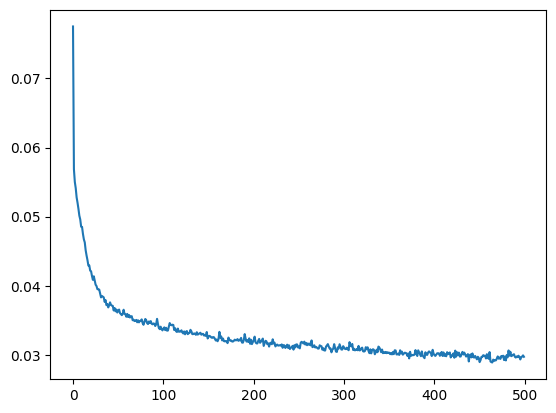

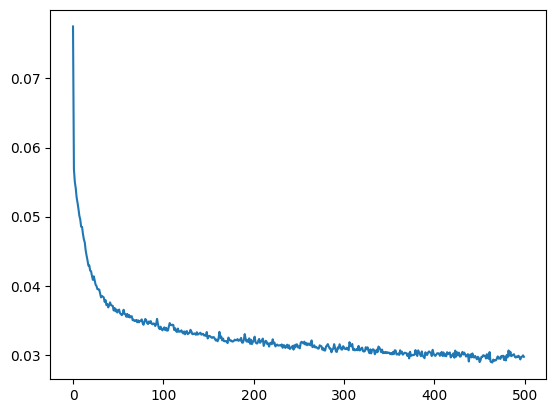

In [4]:
# Plot training history
plt.figure()
plt.plot(history.history['loss'])
plt.figure()
plt.plot(history.history['mean_squared_error'])
plt.show()



   1/1125 [..............................] - ETA: 19s

1125/1125 [==============================] - 1s 1ms/step


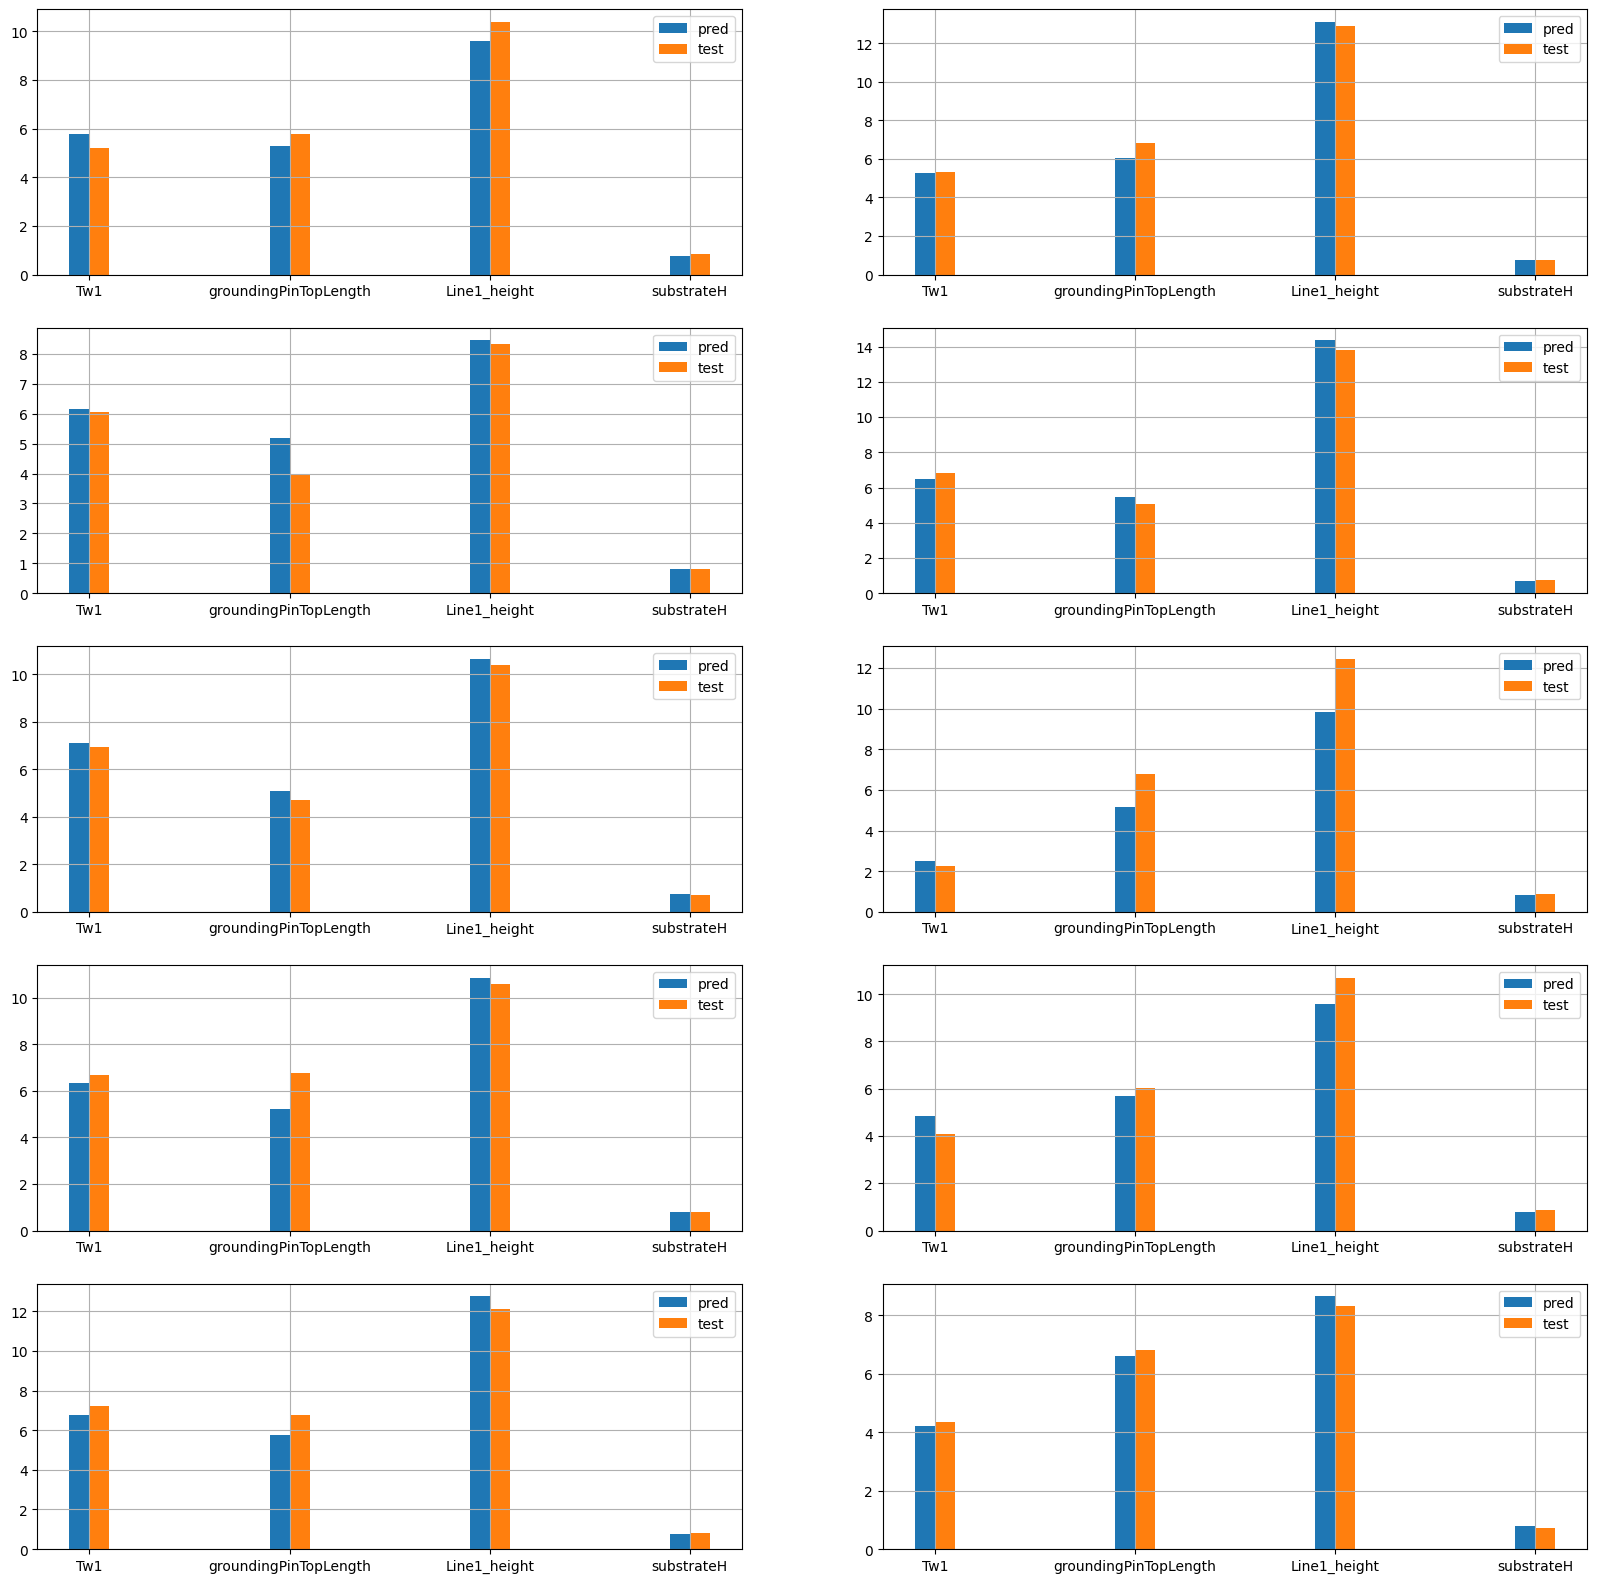

In [7]:
PLOT_TEST = True
# Plot the testing results
if PLOT_TEST:
    if WIRE_ANTENNA:
        # Make a grouped bar plot with the predicted parameters and the test parameters
        y_pred = model.predict(X_test)

        random_indices = random.sample(range(0, y_pred.shape[0]), 10)
        plt.figure(figsize=(10, 10))
        width = 0.1  # the width of the bars
        labels = ["Wire length", "Wire height", "Wire thickness"]
        for idx, i in enumerate(random_indices):
            plt.subplot(5, 2, idx+1)
            plt.grid(True)
            bars1 = plt.bar(np.arange(1,4) - width/2, normalize_data(y_pred[i],np.mean(parameter),np.std(parameter), True), width)
            bars2 = plt.bar(np.arange(1,4) + width/2, normalize_data(y_test[i],np.mean(parameter),np.std(parameter), True), width)
            plt.xticks(np.arange(1,4), labels)
            plt.legend([bars1, bars2], ['pred', 'test'])
        
    else:
        y_pred = model.predict(X_test)
        random_indices = random.sample(range(0, y_pred.shape[0]), 10)
        plt.figure(figsize=(20, 20))
        width = 0.1  # the width of the bars
        labels = ['Tw1','groundingPinTopLength','Line1_height','substrateH']
        for idx, i in enumerate(random_indices):
            plt.subplot(5, 2, idx+1)
            plt.grid(True)
            bars1 = plt.bar(np.arange(1,5) - width/2, normalize_data(y_pred[i],np.mean(parameter),np.std(parameter), True), width)
            bars2 = plt.bar(np.arange(1,5) + width/2, normalize_data(y_test[i], np.mean(parameter), np.std(parameter), True), width)
            plt.xticks(np.arange(1,5), labels)
            plt.legend([bars1, bars2], ['pred', 'test'])
    plt.show()


In [8]:
# Save model
if WIRE_ANTENNA == True:
    model.save('data/Wire_Results/Reverse2ForwardWire_model.keras')
else:
    model.save('data/MIFA_results/Reverse2ForwardMIFA_model.keras')